In [42]:
import cv2
import numpy as np
from numpy import unravel_index
from matplotlib import pyplot as plt
import math
import random

sample1 = cv2.imread("hw4_sample_images/sample1.png", cv2.IMREAD_GRAYSCALE)
sample2 = cv2.imread("hw4_sample_images/sample2.png", cv2.IMREAD_GRAYSCALE)
sample3 = cv2.imread("hw4_sample_images/sample3.png", cv2.IMREAD_GRAYSCALE)

(622, 622)

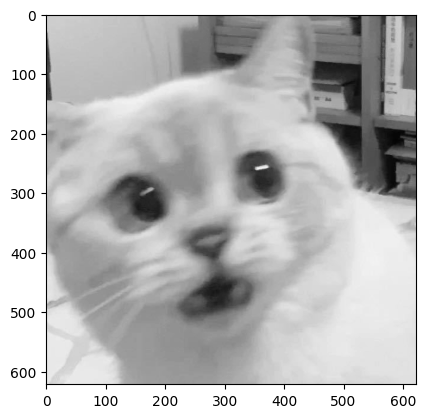

In [43]:
plt.imshow(sample1,cmap='gray')
sample1.shape

In [44]:
def add_gauss_noise(img):
    height,width=img.shape
    mean = 0
    var = 0.1
    sigma = var**0.5
    gauss = np.random.normal(mean,sigma,(height,width))
    gauss = gauss.reshape(height,width)
    noisy = img + gauss
    return noisy

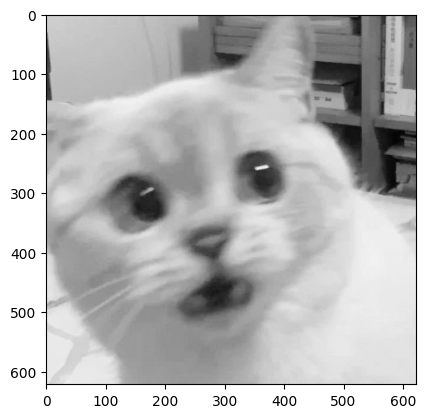

In [45]:
noisy_sample1=add_gauss_noise(sample1)
plt.imshow(noisy_sample1,cmap='gray')

In [46]:
# dither_matrix_size must be power of 2
def dithering(img,dither_matrix_size):
    n=int(math.log2(dither_matrix_size))
    I=np.array([[1,2],[3,0]])
    N=2
    for _ in range(1,n):
        res_I=np.zeros((N*2,N*2))
        res_I[0:N,0:N]=I*4+1
        res_I[N:N*2,0:N]=I*4+3
        res_I[0:N,N:N*2]=I*4+2
        res_I[N:N*2,N:N*2]=I*4
        I=res_I
        N*=2
    height,width=img.shape
    threshold=np.zeros((height,width))
    T=255*(I+0.5)/(N*N)
    threshold[0:(height//N)*N,0:(width//N)*N]=np.tile(T,(height//N,width//N))
    for i in range(0,height-(height//N)*N):
        threshold[(height//N)*N+i][:]=threshold[i][:]
    for j in range(0,width-(width//N)*N):
        threshold.transpose()[(width//N)*N+j][:]=threshold.transpose()[j][:]
    res=np.zeros((height,width))
    res[img>=threshold]=1
    return res

True

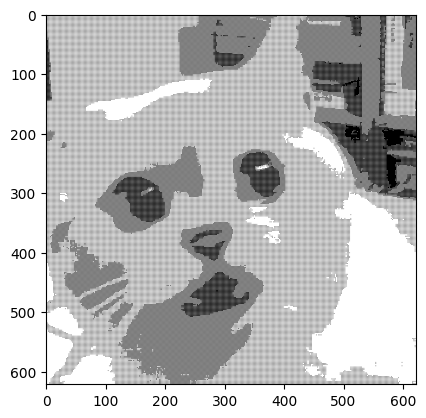

In [47]:
result1 = dithering(noisy_sample1,2)
plt.imshow(result1,cmap='gray')
cv2.imwrite('result1.png',result1*255)

True

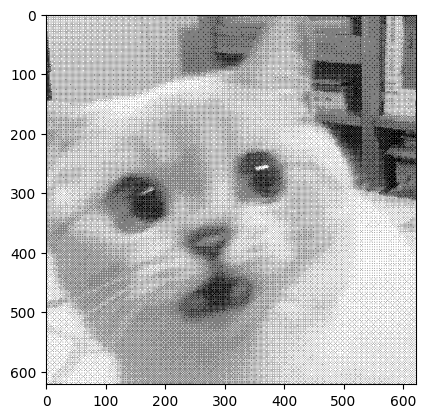

In [48]:
result2 = dithering(noisy_sample1,256)
plt.imshow(result2,cmap='gray')
cv2.imwrite('result2.png',result2*255)

In [49]:
# 步驟是：
#   先把點normalize到0-1之間
#   一個個點跑：>=0.5設為1，<設0
#       原本作為normalize的值減掉設為0/1的值,為error
#       將error擴散出去（如果那個地方點存在的話）
Floyd_Steinberg=np.array([[0,0,0],[0,0,7],[3,5,1]])/16
Jarvis_et_al=np.array([[0,0,0,0,0],[0,0,0,0,0],[0,0,0,7,5],[3,5,7,5,3],[1,3,5,3,1]])/48
def error_diffusion(img,filter_mask):
    height,width=img.shape
    normalize=img/255
    pad_size=filter_mask.shape[0]//2
    normalize=np.pad(normalize,(pad_size,pad_size),'constant',constant_values=(0,0))
    res=np.zeros(normalize.shape)
    for i in range(pad_size,pad_size+height):
        for j in range(pad_size,pad_size+width):
            if normalize[i][j]>=0.5:
                res[i][j]=1
            e=normalize[i][j]-res[i][j]
            normalize[i-pad_size:i+pad_size+1,j-pad_size:j+pad_size+1]+=filter_mask*e
    return res[pad_size:pad_size+height,pad_size:pad_size+width]

True

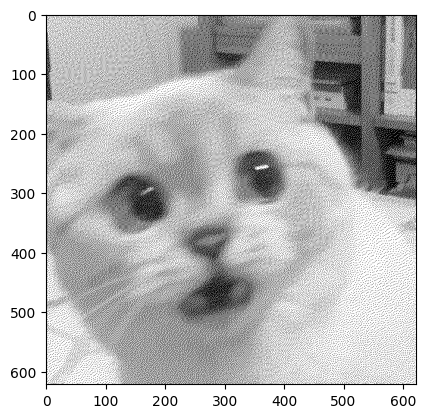

In [50]:
result3=error_diffusion(sample1,Floyd_Steinberg)
plt.imshow(result3,cmap='gray')
cv2.imwrite('result3.png',result3*255)

True

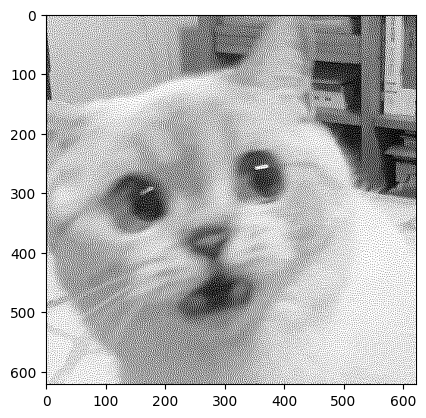

In [51]:
result4=error_diffusion(sample1,Jarvis_et_al)
plt.imshow(result4,cmap='gray')
cv2.imwrite('result4.png',result4*255)

In [52]:
def error_diffusion_with_serpentine_scanning(img,filter_mask):
    height,width=img.shape
    normalize=img/255
    pad_size=filter_mask.shape[0]//2
    reversed_filter_mask=filter_mask[::,::-1]
    normalize=np.pad(normalize,(pad_size,pad_size),'constant',constant_values=(0,0))
    res=np.zeros(normalize.shape)
    for i in range(pad_size,pad_size+height):
        if i % 2 ==0:
            for j in range(pad_size,pad_size+width):
                if normalize[i][j]>=0.5:
                    res[i][j]=1
                e=normalize[i][j]-res[i][j]
                normalize[i-pad_size:i+pad_size+1,j-pad_size:j+pad_size+1]+=filter_mask*e
        elif i % 2 ==1:
            for j in reversed(range(pad_size,pad_size+width)):
                if normalize[i][j]>=0.5:
                    res[i][j]=1
                e=normalize[i][j]-res[i][j]
                normalize[i-pad_size:i+pad_size+1,j-pad_size:j+pad_size+1]+=reversed_filter_mask*e
    return res[pad_size:pad_size+height,pad_size:pad_size+width]

True

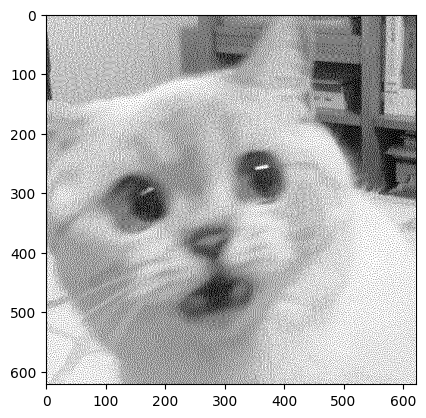

In [53]:
result3_with_SS=error_diffusion_with_serpentine_scanning(sample1,Floyd_Steinberg)
plt.imshow(result3_with_SS,cmap='gray')
cv2.imwrite("result3_with_SS.png",result3_with_SS*255)

True

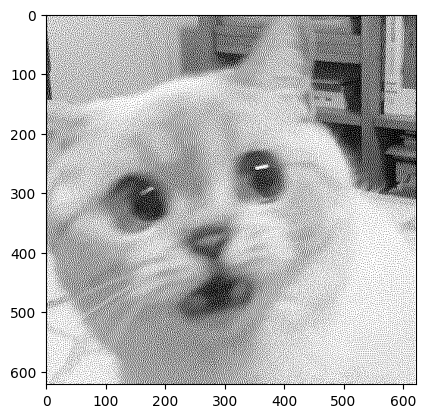

In [54]:
result4_with_SS=error_diffusion_with_serpentine_scanning(sample1,Jarvis_et_al)
plt.imshow(result4_with_SS,cmap='gray')
cv2.imwrite("result4_with_SS.png",result4_with_SS*255)

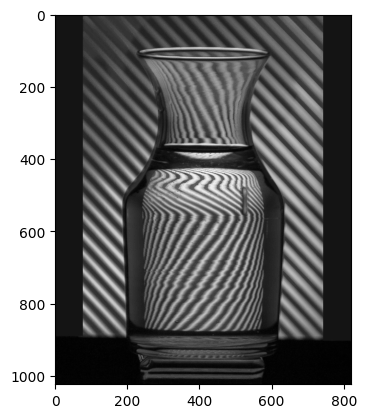

In [55]:
def image_sampling(img,sampling_rate):
    sampling=int(1//sampling_rate)
    return img[::sampling,::sampling]
result5=image_sampling(sample2,0.5)
plt.imshow(result5,cmap='gray')

True

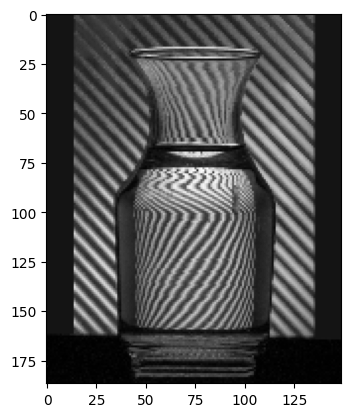

In [56]:
result5_aliasing=image_sampling(sample2,0.09)
plt.imshow(result5_aliasing,cmap='gray')
cv2.imwrite('result5.png',result5_aliasing)

In [57]:
def Gaussian_high_pass_filter(D0,img_shape):
    height=img_shape[0]
    width=img_shape[1]
    filter = np.zeros((height,width), dtype=np.float32)
    for i in range(height):
        for j in range(width):
            D = np.sqrt((i-height/2)**2 + (j-width/2)**2)
            filter[i,j] = 1-np.exp(-D**2/(2*D0*D0))
    return filter

In [58]:
def GHPF_in_freq_domain(img,d0):
    height,width=img.shape
    img_freq= np.fft.fft2(img)
    img_freq_center=np.fft.fftshift(img_freq)
    
    plt.subplot(131), plt.imshow(np.log(1+np.abs(img_freq_center)),cmap='gray')

    res_freq_center=img_freq_center*Gaussian_high_pass_filter(d0,(height,width))

    # plt.imshow(Gaussian_high_pass_filter(d0,(height,width)),cmap='gray')

    plt.subplot(132), plt.imshow(np.log(1+np.abs(res_freq_center)),cmap='gray')

    res_freq=np.fft.ifftshift(res_freq_center)
    res = np.fft.ifft2(res_freq)
    res = np.clip(np.abs(res), 0, 255).astype("uint8")
    return res


True

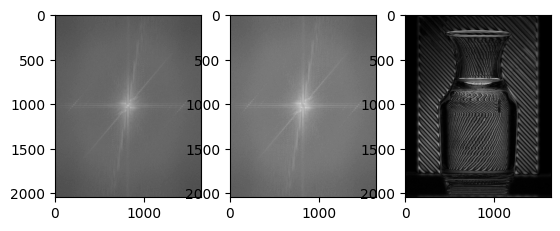

In [59]:
result6_15 = GHPF_in_freq_domain(sample2,15)

plt.subplot(133),plt.imshow(result6_15,cmap='gray')
cv2.imwrite('result6_15.png',result6_15)

True

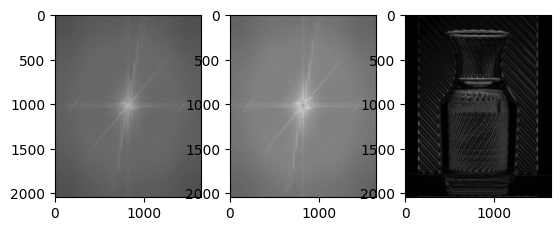

In [60]:
result6 = GHPF_in_freq_domain(sample2,30)

plt.subplot(133),plt.imshow(result6,cmap='gray')
cv2.imwrite('result6.png',result6)

True

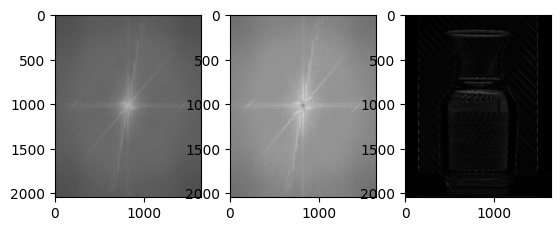

In [61]:
result6_80 = GHPF_in_freq_domain(sample2,80)

plt.subplot(133),plt.imshow(result6_80,cmap='gray')
cv2.imwrite('result6_80.png',result6_80)

In [62]:
import string
# for "vertical seam":seam_orient='v', for "horizontal seam":seam_orient='h'
def find_largest_seam(energy_map:np.ndarray, seam_num:int, seam_orient:string):
    height,width = energy_map.shape
    max_E = np.zeros((height,width))
    max_O = np.zeros((height,width))
    seam_map = np.zeros((height,width))
    if seam_orient == 'v':
        max_E[0][:]=energy_map[0][:]
        max_O[0][:]=-1
        for i in range(1,height):
            for j in range(0,width):
                e=energy_map[i][j]
                ancestor = {}
                if j == 0:
                    ancestor[1]=max_E[i-1][j]
                    ancestor[2]=max_E[i-1][j+1]
                elif j == width-1:
                    ancestor[0]=max_E[i-1][j-1]
                    ancestor[1]=max_E[i-1][j]
                else:
                    ancestor[0]=max_E[i-1][j-1]
                    ancestor[1]=max_E[i-1][j]
                    ancestor[2]=max_E[i-1][j+1]
                max_E[i][j]=max(ancestor.values())+e
                max_O[i][j]=max(ancestor,key=ancestor.get)
    elif seam_orient == 'h':
        max_E.transpose()[0][:]=energy_map.transpose()[0][:]
        max_O.transpose()[0][:]=-1
        for j in range(1,width):
            for i in range(0,height):
                e=energy_map[i][j]
                ancestor = {}
                if i == 0:
                    ancestor[1]=max_E[i][j-1]
                    ancestor[2]=max_E[i+1][j-1]
                elif i == height-1:
                    ancestor[0]=max_E[i-1][j-1]
                    ancestor[1]=max_E[i][j-1]
                else:
                    ancestor[0]=max_E[i-1][j-1]
                    ancestor[1]=max_E[i][j-1]
                    ancestor[2]=max_E[i+1][j-1]
                max_E[i][j]=max(ancestor.values())+e
                max_O[i][j]=max(ancestor,key=ancestor.get)
    largest_k=np.array([(x,-float('inf')) for x in range(seam_num)],dtype=[('index','<i4'),('total_energy','<f4')])
    if seam_orient == 'v':
        for j in range(width):
            for k in range(seam_num):
                if max_E[height-1][j] > largest_k['total_energy'][k]:
                    largest_k[k]=(j,max_E[height-1][j])
                    break
        for k in range(seam_num):
            j=largest_k['index'][k]
            for i in reversed(range(height)):
                seam_map[i][j]=-1
                if max_O[i][j]==0:
                    j-=1
                elif max_O[i][j]==2:
                    j+=1
    elif seam_orient == 'h':
        for i in range(height):
            for k in range(seam_num):
                if max_E[i][width-1] > largest_k['total_energy'][k]:
                    largest_k[k]=(i,max_E[i][width-1])
                    break
        for k in range(seam_num):
            i=largest_k['index'][k]
            for j in reversed(range(width)):
                seam_map[i][j]=-1
                if max_O[i][j]==0:
                    i-=1
                elif max_O[i][j]==2:
                    i+=1
    return seam_map

In [63]:
def remove_horizontal_ripple(img):
    height,width=img.shape
    img_freq= np.fft.fft2(img)
    img_freq_center=np.fft.fftshift(img_freq)
    to_show=np.log(1+np.abs(img_freq_center))
    plt.subplot(121)
    plt.imshow(to_show,cmap='gray')
    res_freq_center=img_freq_center.copy()

    
    reserve_map=find_largest_seam(res_freq_center,100,'h')

    for _ in range(1):
        remove_map=find_largest_seam(res_freq_center,1,"v")
        for i in range(height):
            for j in range(width):
                if remove_map[i][j]==-1 and reserve_map[i][j]!=-1:
                    res_freq_center[i][j]=0
        # res_freq_center[remove_map==-1]=0
    plt.subplot(122),plt.imshow(np.log(1+np.abs(res_freq_center)),cmap='gray')

    res_freq=np.fft.ifftshift(res_freq_center)
    res = np.fft.ifft2(res_freq)
    res = np.clip(np.abs(res), 0, 255).astype("uint8")
    return res

/tmp/ipykernel_4707/3055003611.py:28: ComplexWarning: Casting complex values to real discards the imaginary part
  max_E.transpose()[0][:]=energy_map.transpose()[0][:]
/tmp/ipykernel_4707/3055003611.py:44: ComplexWarning: Casting complex values to real discards the imaginary part
  max_E[i][j]=max(ancestor.values())+e
/tmp/ipykernel_4707/3055003611.py:9: ComplexWarning: Casting complex values to real discards the imaginary part
  max_E[0][:]=energy_map[0][:]
/tmp/ipykernel_4707/3055003611.py:25: ComplexWarning: Casting complex values to real discards the imaginary part
  max_E[i][j]=max(ancestor.values())+e


True

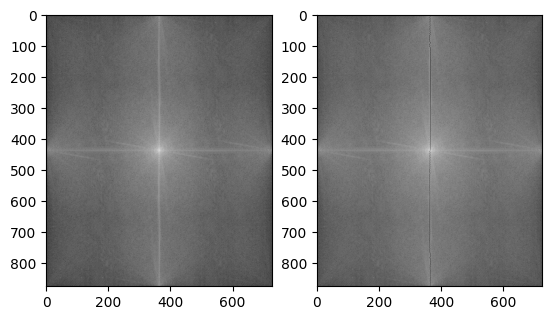

In [64]:
result7_1 = remove_horizontal_ripple(sample3)
# plt.imshow(result7,cmap='gray')
cv2.imwrite("result7_1.png",result7_1)

In [65]:
def remove_horizontal_ripple(img):
    height,width=img.shape
    img_freq= np.fft.fft2(img)
    img_freq_center=np.fft.fftshift(img_freq)
    to_show=np.log(1+np.abs(img_freq_center))
    plt.subplot(121)
    plt.imshow(to_show,cmap='gray')
    res_freq_center=img_freq_center.copy()

    for_find_reverse_part=img_freq_center.copy()
    reserve_map=np.zeros((height,width))
    for _ in range(10):
        reserve_seam=find_largest_seam(for_find_reverse_part,1,'h')
        for_find_reverse_part[reserve_seam==-1]=0
        reserve_map[reserve_seam==-1]=-1

    for _ in range(3):
        remove_map=find_largest_seam(res_freq_center,1,"v")
        for i in range(height):
            for j in range(width):
                if remove_map[i][j]==-1 and reserve_map[i][j]!=-1:
                    res_freq_center[i][j]=0
    plt.subplot(122),plt.imshow(np.log(1+np.abs(res_freq_center)),cmap='gray')

    res_freq=np.fft.ifftshift(res_freq_center)
    res = np.fft.ifft2(res_freq)
    res = np.clip(np.abs(res), 0, 255).astype("uint8")
    return res

/tmp/ipykernel_4707/3055003611.py:28: ComplexWarning: Casting complex values to real discards the imaginary part
  max_E.transpose()[0][:]=energy_map.transpose()[0][:]
/tmp/ipykernel_4707/3055003611.py:44: ComplexWarning: Casting complex values to real discards the imaginary part
  max_E[i][j]=max(ancestor.values())+e
/tmp/ipykernel_4707/3055003611.py:9: ComplexWarning: Casting complex values to real discards the imaginary part
  max_E[0][:]=energy_map[0][:]
/tmp/ipykernel_4707/3055003611.py:25: ComplexWarning: Casting complex values to real discards the imaginary part
  max_E[i][j]=max(ancestor.values())+e


True

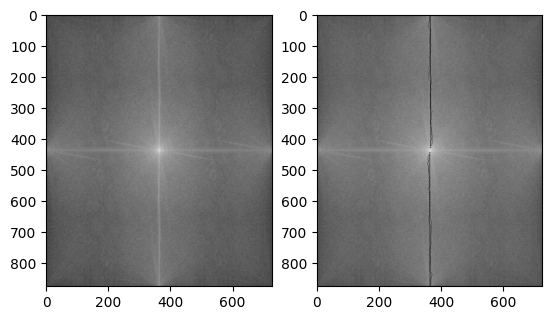

In [66]:
result7 = remove_horizontal_ripple(sample3)
# plt.imshow(result7,cmap='gray')
cv2.imwrite("result7.png",result7)

In [67]:
def remove_horizontal_ripple(img):
    height,width=img.shape
    img_freq= np.fft.fft2(img)
    img_freq_center=np.fft.fftshift(img_freq)
    to_show=np.log(1+np.abs(img_freq_center))
    plt.subplot(121)
    plt.imshow(to_show,cmap='gray')
    res_freq_center=img_freq_center.copy()

    
    reserve_map=find_largest_seam(res_freq_center,100,'h')

    for _ in range(10):
        remove_map=find_largest_seam(res_freq_center,1,"v")
        for i in range(height):
            for j in range(width):
                if remove_map[i][j]==-1 and reserve_map[i][j]!=-1:
                    res_freq_center[i][j]=0
        # res_freq_center[remove_map==-1]=0
    plt.subplot(122),plt.imshow(np.log(1+np.abs(res_freq_center)),cmap='gray')

    res_freq=np.fft.ifftshift(res_freq_center)
    res = np.fft.ifft2(res_freq)
    res = np.clip(np.abs(res), 0, 255).astype("uint8")
    return res

/tmp/ipykernel_4707/3055003611.py:28: ComplexWarning: Casting complex values to real discards the imaginary part
  max_E.transpose()[0][:]=energy_map.transpose()[0][:]
/tmp/ipykernel_4707/3055003611.py:44: ComplexWarning: Casting complex values to real discards the imaginary part
  max_E[i][j]=max(ancestor.values())+e
/tmp/ipykernel_4707/3055003611.py:9: ComplexWarning: Casting complex values to real discards the imaginary part
  max_E[0][:]=energy_map[0][:]
/tmp/ipykernel_4707/3055003611.py:25: ComplexWarning: Casting complex values to real discards the imaginary part
  max_E[i][j]=max(ancestor.values())+e


True

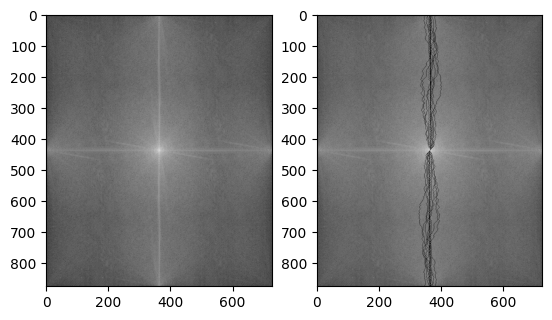

In [68]:
result7_2 = remove_horizontal_ripple(sample3)
# plt.imshow(result7,cmap='gray')
cv2.imwrite("result7_2.png",result7_2)